In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Introduction
Tabular Data Problem statements observe good results by using ensemble of Decision Trees, Such as Random forests and Gradient Boosting Machines.

In [2]:
# Importing basic set of libraries
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Data Preprocessing

In [3]:
import os
isKaggle= os.environ.get('KAGGLE_KERNEL_RUN_TYPE')

if isKaggle: path = Path('../input/titanic')
else:
    import zipfile, kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)
    
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [4]:
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [5]:
df.index

RangeIndex(start=0, stop=891, step=1)

In Random Forests, we don't generally require to create dummy variables like we did for non-numeric columns(Categorical) in the linear models and neural network.

We can convert those fields to Pandas Categorical variables, which internally in Pandas makes a list of all unique values in the column and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values


In [6]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df.Fare)
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
proc_data(df)
proc_data(test_df)

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


We'll make a list of the continous, categorical and dependent variables. 
- we don't consider Pclass a categorical variable. That's because it's ordered(1,2 and 3)
- And decision trees only care about ordered values not the absolute values

In [8]:
cats = ["Sex", "Embarked"]
conts = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dep = "Survived"

In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [10]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

- "Sex" column is still shown as categorical column in padas.
- However, bts they're now stored as integers, with indices that are looked up in the categories code list shown above(df.Sex.cat.codes)  

# Binary Split/One R
- Fragmented unit of Decision tree later Random Forest or Gradient Boosting Machine

Blueprint
- All rows are split into one of two groups
- based on whether they are above/below some threshold of some column
- Eg: Splitting rows of dataset based on the column 'Sex' by using threshold 0.5

Visualizing using Seaborn library

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


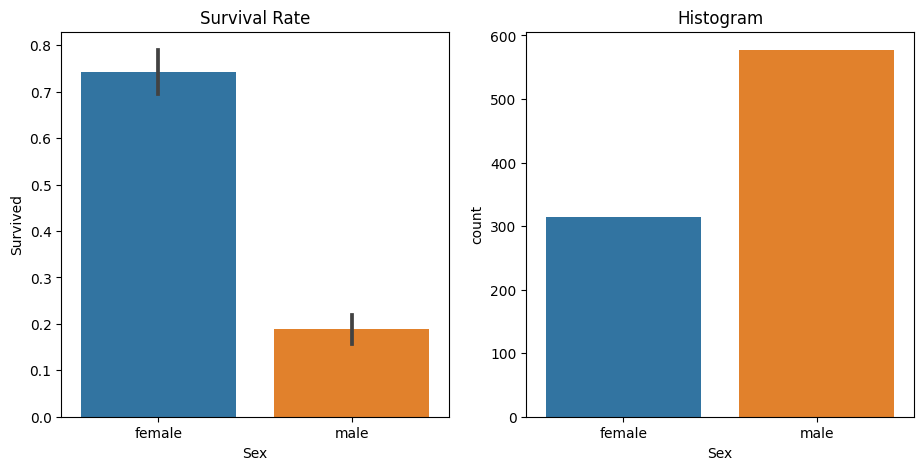

In [11]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(11, 5))
sns.barplot(data=df, y=dep, x='Sex', ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

- Splitting data by Gender is giving quite a good ratios in terms of the survival rate and the number of female/male in the group

- We could create a model which simply says that all female survive and no males do.

In [12]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
# Replacing the categorical values with the codes
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [13]:
trn_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
298,299,1,1,"Saalfeld, Mr. Adolphe",1,24.00,0,0,19988,30.5000,C106,2,3.449988
884,885,0,3,"Sutehall, Mr. Henry Jr",1,25.00,0,0,SOTON/OQ 392076,7.0500,B96 B98,2,2.085672
247,248,1,2,"Hamalainen, Mrs. William (Anna)",0,24.00,0,2,250649,14.5000,B96 B98,2,2.740840
478,479,0,3,"Karlsson, Mr. Nils August",1,22.00,0,0,350060,7.5208,B96 B98,2,2.142510
305,306,1,1,"Allison, Master. Hudson Trevor",1,0.92,1,2,113781,151.5500,C22 C26,2,5.027492


In [14]:
# Creating independent variable 'x' and dependent variable 'y'
def xs_y(df):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

### Making prediction

In [15]:
preds = val_xs.Sex == 0

In [16]:
# Measuring Accuracy with mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

### Alternative (LogFare Based Split)
- We can try splitting continous column like LogFare

In [17]:
df_fare = trn_df[trn_df.LogFare>0]
len(df_fare.index)

655

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LogFare', ylabel='Density'>

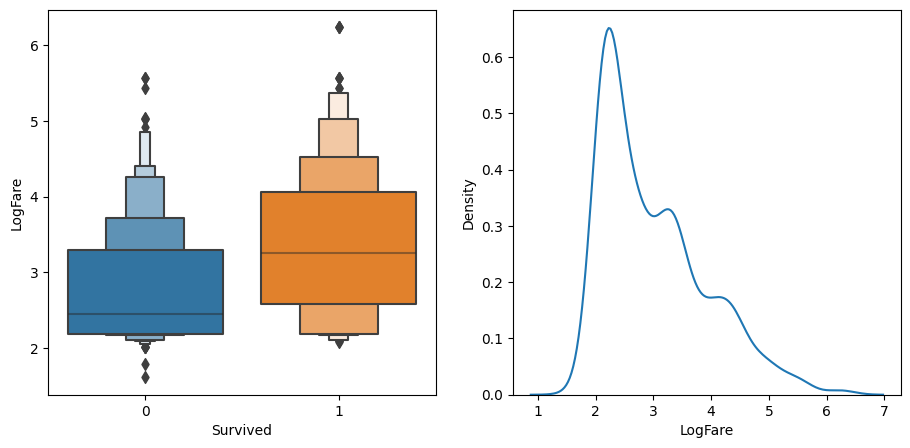

In [18]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=axs[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])

The boxenplot above shows quantiles of LogFare for each group of Survived==0 and Survived==1. It shows that the average LogFare for passengers that didn't survive is around 2.5, and for those that did it's around 3.2. So it seems that people that paid more for their tickets were more likely to get put on a lifeboat.

In [19]:
preds= val_xs.LogFare>2.7

In [20]:
mean_absolute_error(val_y, preds)

0.336322869955157

- Less accurate then 'Sex' based split prediction

- We'd like someway to try more columns and breakpoints more easily. 
- We could create a function that returns how good our model is, so we can try more splits.

- `Score` function wouold be used to do this, Instead of MAE we'll calculate measure of Impurity

**Measure of Impurity:** How much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

> We can measure the similarity of rows inside the group by taking the Standard Deviation of the Dependent Variable\
If Higher than rows are diversed and vice versa
We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [21]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Now we can calculate the score for a split by adding up the scores for the LHS and RHS

In [22]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs, y) + _side_score(~lhs,y))/len(y)

In [23]:
# For eg. Score of the impurity
score(trn_xs['Sex'], trn_y, 0.5)

0.40787530982063946

In [24]:
# Impurity score for LogFare split at 2.7
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

Trying multiple split with interactive tool

In [25]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [26]:
# Doing same for Categorical Columns
interact(nm=cats, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), FloatSlider(value=…

### Finding split with automatization

In [27]:
nm = 'Age'
col = trn_xs['Age']
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [28]:
# Finding the lowest Impurity measure for all the above split
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

Based on this, it looks like, for instance, that for the Age column, 6 is the optimal cutoff according to our training set.

### Implementing automatic split finder for all columns


In [29]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx], scores[idx]

min_col(trn_df, 'Age')

(6.0, 0.478316717508991)

In [30]:
# Trying for all columns
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

ccording to this, Sex<=0 is the best split we can use.

We've just re-invented the OneR classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993.

- We found earlier that out OneR rule had an error of around 0.215, so we'll keep that in mind as we try out more sophisticated approaches.